In [60]:
import sys
import numpy as np
from normflows import config, flows, distributions
from autograd.misc.optimizers import adam, rmsprop, sgd

import matplotlib.pyplot as plt

if str(config.root / 'src') not in sys.path:
    sys.path.append(str(config.root / 'src'))
    
import learning_basic_flow as lbf
import learning_gaussian_mixture as lgm

%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext line_profiler

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


 50%|█████     | 1/2 [01:28<00:47, 47.56s/it]

Iteration 0; gradient mag: 129756.719


100%|██████████| 2/2 [02:07<00:00, 63.77s/it]


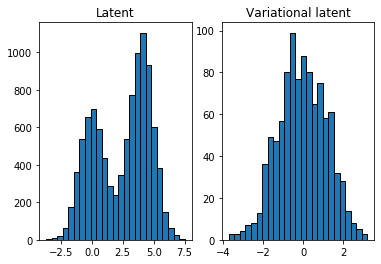

In [63]:
%lprun -f distributions.log_mvn lgm.main()

In [150]:
xx.shape

(100, 1)

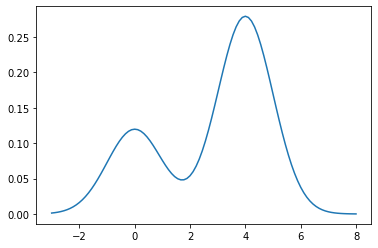

In [51]:
mus = np.array([[0], [4]])
Sigma_diags = np.array([[1], [1]])
# probs = np.array([0.3, 0.7])
pi = np.array([0.3])
xx = np.linspace(-3, 8, 100).reshape(-1, 1)
yy = distributions.prob_gm(xx, mus, Sigma_diags, pi)
plt.plot(xx, yy)
plt.show()

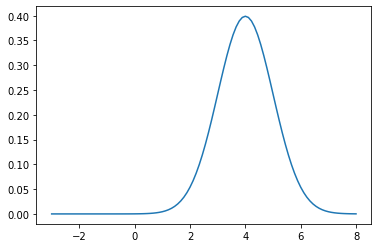

In [52]:
mu = np.array([[4]])
sigma_diag = np.array([[1]])
yy = distributions.mvn(xx, mu, sigma_diag)
plt.plot(xx, yy)
plt.show()

In [106]:
yy.shape

(1, 1)

In [53]:
K = 3
D = 1
G = 2
n_samples = 500
n_iter = 200


Z = lgm.get_gmm_samples(n_samples=n_samples)
X = lgm.f_true(Z)

res = lgm.run_optimization(X, K, D, G, max_iter=n_iter, N=n_samples)

  4%|▍         | 8/200 [00:00<00:10, 18.39it/s]

Iteration 0; gradient mag: 50354.032


 55%|█████▌    | 110/200 [00:02<00:01, 49.57it/s]

Iteration 100; gradient mag: 64793.935


100%|██████████| 200/200 [00:04<00:00, 48.63it/s]


In [54]:
res[1].shape

(19, 200)

In [55]:
def unpack_param_trace(params):
    phi = params[:2 * D * (1 + K) + K]
    theta = params[2 * D * (1 + K) + K:]

    phi = unpack_phi_trace(phi)
    theta = unpack_theta_trace(theta)

    return phi, theta

def unpack_phi_trace(phi):
    mu0 = phi[:D]
    log_sigma_diag0 = phi[D:2 * D]
    W = phi[2 * D:2 * D + K * D].reshape(K, D, n_iter)
    U = phi[2 * D + K * D:2 * (D + K * D)].reshape(K, D, n_iter)
    b = phi[-K:]

    return mu0, log_sigma_diag0, W, U, b

def unpack_theta_trace(theta):
    mu_z = theta[:D * G].reshape(G, D, n_iter)
    log_sigma_diag_pz = theta[D * G: 2 * D * G].reshape(G, D, n_iter)
    pi = theta[2 * D * G:2 * D * G + G - 1]
    A = theta[-(D ** 2 + 2 * D):-2 * D].reshape(D, D, n_iter)
    B = theta[-2 * D:-D]
    log_sigma_diag_lklhd = theta[-D:]

    return mu_z, log_sigma_diag_pz, pi, A, B, log_sigma_diag_lklhd


phi, theta = unpack_param_trace(res[1])

In [56]:
mu0, log_sigma_diag0, W, U, b = phi
mu_z, log_sigma_diag_pz, pi, A, B, log_sigma_diag_lklhd = theta

In [57]:
log_sigma_diag_pz.shape

(2, 1, 200)

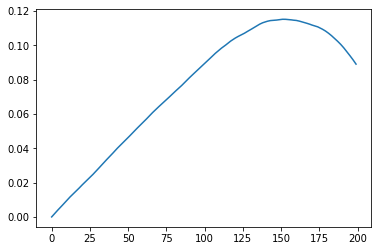

In [58]:
plt.plot(log_sigma_diag_pz[1].flatten())
plt.show()

In [62]:
help(sgd)

Help on function sgd in module autograd.misc.optimizers:

sgd(grad, x0, callback=None, *args, **kwargs)
    Stochastic gradient descent with momentum.
    grad() must have signature grad(x, i), where i is the iteration number.

